In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  # natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import tensorflow
pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
def tf_randomness_control(seed=0):
  import os
  import random
  import tensorflow as tf
  tf.config.experimental.enable_op_determinism()
  seed=0
  os.environ['PYTHONHASHSEED'] = str(seed)
  # For working on GPUs from "TensorFlow Determinism"
  os.environ["TF_DETERMINISTIC_OPS"] = str(seed)
  np.random.seed(seed)
  random.seed(seed)
  tf.random.set_seed(seed)
  tensorflow.random.set_seed(0)
tf_randomness_control(0)

# **mount google drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**read data from google drive**

In [6]:
!cp /content/drive/MyDrive/data_to_process/tweets_sentiment_1.4/bitcoin-tweets-14m.zip   /content
!cp   /content/drive/MyDrive/data_to_process/tweets_sentiment_1.4/btc-price.zip  /content

**unzip data**

In [ ]:
!unzip bitcoin-tweets-14m.zip

Archive:  bitcoin-tweets-14m.zip
  inflating: cleanprep.csv           


In [ ]:
!unzip btc-price.zip

Archive:  btc-price.zip
  inflating: btcSave2.csv            


In [ ]:
!mv cleanprep.csv tweets_data.csv

In [ ]:
!mv btcSave2.csv bitcoin_price_data.csv

# **read and preprocess Tweet dataset**

In [ ]:
tweets_data = pd.read_csv('tweets_data.csv',header = None)
tweets_data.head()

,0,1,2,3,4
0,2018-07-11 19:35:15.363270,b'tj',"b""Next two weeks prob v boring (climb up to 9k...",0.007273,0.590909
1,2018-07-11 19:35:15.736769,b'Kool_Kheart',b'@Miss_rinola But you\xe2\x80\x99ve heard abo...,0.000000,0.000000
2,2018-07-11 19:35:15.744769,b'Gary Lang',b'Duplicate skilled traders automatically with...,0.625000,0.500000
3,2018-07-11 19:35:15.867339,b'Jobs in Fintech',b'Project Manager - Technical - FinTech - Cent...,0.000000,0.175000
4,2018-07-11 19:35:16.021448,b'ERC20',"b'Coinbase App Downloads Drop, Crypto Hype Fad...",0.333333,0.500000


In [ ]:
tweets_data.columns =['dt', 'name','tweet','polarity','sensitivity']
tweets_data=tweets_data.drop(['name','polarity','sensitivity'], axis=1)
tweets_data["dt"]= pd.to_datetime(tweets_data['dt'])
tweets_data['DateTime'] = tweets_data['dt'].dt.floor('h')
tweets_data=tweets_data.drop(['dt'], axis=1)
# tweets_data=tweets_data.set_index('DateTime')
tweets_data.head()

,tweet,DateTime
0,"b""Next two weeks prob v boring (climb up to 9k...",2018-07-11 19:00:00
1,b'@Miss_rinola But you\xe2\x80\x99ve heard abo...,2018-07-11 19:00:00
2,b'Duplicate skilled traders automatically with...,2018-07-11 19:00:00
3,b'Project Manager - Technical - FinTech - Cent...,2018-07-11 19:00:00
4,"b'Coinbase App Downloads Drop, Crypto Hype Fad...",2018-07-11 19:00:00


In [ ]:
tempdf=tweets_data.copy(deep=True)
tempdf.shape

(1413001, 2)

In [ ]:
tempdf=tempdf.iloc[0:10000,:]

# **apply NLP on tweet dataset**

**cleaning tweets text**

In [ ]:
import re
tf_randomness_control(0)
def clean_text(s):

    s=re.sub(r'[^\x00-\x7F]',' ', s)
    s=re.sub('\\xe2\\x80\\x99',' ',s)
    s=re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', s) #remove any link
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    s = s.replace("\\xe2\\x80\\x99", " ").replace("\\xe2\\x80\\x99", " ")
    s = s.replace("\\xe2\\x86\\x92", " ").replace("\\xe2\\x86\\x92", " ")
    s = s.replace("\\xf0\\x9f\\x98\\x88", " ").replace("\\xf0\\x9f\\x98\\x88", " ")
    s = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', s)
    s=str(s)
    s = s.replace('b\'', '')
    s=re.sub('[^\x00-\x7F]','', s)  #remove  characters start with \x

    return s

# tweets_data['clean_tweet'] = tweets_data['tweet'].apply(clean_text)
tempdf['clean_tweet'] = tempdf['tweet'].apply(clean_text)

**remove stopwords**

In [ ]:
from collections import Counter
cachedStopWords = stopwords.words("english")
stopwords_dict = Counter(cachedStopWords)
tf_randomness_control(0)
def tweet_to_words(text):
    ''' Convert tweet text into a sequence of words '''

    # convert to lowercase
    # text = tweet.lower()  #commented just for Vader-  VADER considers the capitalized version to have stronger sentiment and increased the sentiment score
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    text=re.sub('[^\x00-\x7F]','', text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords_dict]
    # apply stemming
    words = [PorterStemmer().stem(w,to_lowercase=False) for w in words]

    # return list
    return words

In [ ]:
tempdf['final_clean'] = tempdf['clean_tweet'].apply(tweet_to_words)
tempdf.head()

,tweet,DateTime,clean_tweet,final_clean
0,"b""Next two weeks prob v boring (climb up to 9k...",2018-07-11 19:00:00,"b""Next two weeks prob boring (climb up to 9k) ...","[b, Next, two, week, prob, bore, climb, 9k, un..."
1,b'@Miss_rinola But you\xe2\x80\x99ve heard abo...,2018-07-11 19:00:00,But you ve heard about BITCOIN?',"[But, heard, BITCOIN]"
2,b'Duplicate skilled traders automatically with...,2018-07-11 19:00:00,Duplicate skilled traders automatically with B...,"[Duplic, skill, trader, automat, Bitcoin, xf0,..."
3,b'Project Manager - Technical - FinTech - Cent...,2018-07-11 19:00:00,Project Manager - Technical - FinTech - Centra...,"[Project, Manag, Technic, FinTech, Central, Lo..."
4,"b'Coinbase App Downloads Drop, Crypto Hype Fad...",2018-07-11 19:00:00,"Coinbase App Downloads Drop, Crypto Hype Fadin...","[Coinbas, App, Download, Drop, Crypto, Hype, F..."


# **compute tweets polarity and sentiment**

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
def unlist(list):
    words=''
    for item in list:
        words+=item+' '
    return words


def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    df["vader_neg"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neg"])
    df["vader_neu"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neu"])
    df["vader_pos"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["pos"])
    df["vader_comp"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["compound"])
    df['cleantext2'] = df[label].apply(lambda x: unlist(x))
    return df

In [ ]:
final_tweet_data = compute_vader_scores(tempdf,'final_clean')
final_tweet_data.head()

,tweet,DateTime,clean_tweet,final_clean,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2
0,"b""Next two weeks prob v boring (climb up to 9k...",2018-07-11 19:00:00,"b""Next two weeks prob boring (climb up to 9k) ...","[b, Next, two, week, prob, bore, climb, 9k, un...",0.101,0.754,0.146,0.2263,b Next two week prob bore climb 9k unless new ...
1,b'@Miss_rinola But you\xe2\x80\x99ve heard abo...,2018-07-11 19:00:00,But you ve heard about BITCOIN?',"[But, heard, BITCOIN]",0.000,1.000,0.000,0.0000,But heard BITCOIN
2,b'Duplicate skilled traders automatically with...,2018-07-11 19:00:00,Duplicate skilled traders automatically with B...,"[Duplic, skill, trader, automat, Bitcoin, xf0,...",0.000,1.000,0.000,0.0000,Duplic skill trader automat Bitcoin xf0 x9f x9...
3,b'Project Manager - Technical - FinTech - Cent...,2018-07-11 19:00:00,Project Manager - Technical - FinTech - Centra...,"[Project, Manag, Technic, FinTech, Central, Lo...",0.000,1.000,0.000,0.0000,Project Manag Technic FinTech Central London E...
4,"b'Coinbase App Downloads Drop, Crypto Hype Fad...",2018-07-11 19:00:00,"Coinbase App Downloads Drop, Crypto Hype Fadin...","[Coinbas, App, Download, Drop, Crypto, Hype, F...",0.130,0.870,0.000,-0.2732,Coinbas App Download Drop Crypto Hype Fade Qui...


In [ ]:
final_sentiments_data=final_tweet_data[["DateTime","vader_neg","vader_neu","vader_pos","vader_comp"]]
final_sentiments_data.head()

,DateTime,vader_neg,vader_neu,vader_pos,vader_comp
0,2018-07-11 19:00:00,0.101,0.754,0.146,0.2263
1,2018-07-11 19:00:00,0.000,1.000,0.000,0.0000
2,2018-07-11 19:00:00,0.000,1.000,0.000,0.0000
3,2018-07-11 19:00:00,0.000,1.000,0.000,0.0000
4,2018-07-11 19:00:00,0.130,0.870,0.000,-0.2732


# **calculate tweets polarity mean hourly**

In [ ]:
final_sentiments_data = final_sentiments_data.groupby('DateTime').agg(lambda x: x.mean())
final_sentiments_data.index.names = ['Timestamp']
final_sentiments_data.head()

,vader_neg,vader_neu,vader_pos,vader_comp
Timestamp,,,,
2018-07-11 19:00:00,0.021204,0.896433,0.060616,0.071327
2018-07-11 20:00:00,0.024701,0.894394,0.063221,0.070042
2018-07-11 21:00:00,0.026609,0.893209,0.061203,0.070412


In [ ]:
final_sentiments_data.shape

(3, 4)

# **read bitcoin data**

In [ ]:
bitcoin_data = pd.read_csv('bitcoin_price_data.csv' )

bitcoin_data['Timestamp'] = pd.to_datetime(bitcoin_data['Timestamp'])
bitcoin_data = bitcoin_data.set_index(pd.DatetimeIndex(bitcoin_data['Timestamp']))
bitcoin_data = bitcoin_data.drop(['Timestamp'], axis=1)
bitcoin_data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Timestamp,,,,,,,
2018-07-10 01:00:00,6666.75,6683.90,6635.59,6669.73,281.73,1875693.72,6657.70
2018-07-10 02:00:00,6662.44,6674.60,6647.00,6647.00,174.10,1160103.29,6663.38
2018-07-10 03:00:00,6652.52,6662.82,6621.99,6632.53,231.41,1536936.22,6641.70
2018-07-10 04:00:00,6631.17,6655.48,6625.54,6635.92,120.38,799154.77,6638.52
2018-07-10 05:00:00,6632.81,6651.06,6627.64,6640.57,94.00,624289.31,6641.32


# **get google trend of bitcoin**

In [ ]:
!pip install pytrends==4.7.3

In [ ]:
from pytrends.request import TrendReq

In [ ]:
start_year=2018
end_year=2018
start_month=6
end_month=7
start_day=9
end_day=25

#keywords to get from google trends
#keywords to get from google trends
my_kw_list=["Bitcoin","BTC"]
#connect to google
pytrends=TrendReq()
#get data
data=pytrends.get_historical_interest(my_kw_list,year_start=start_year,
                                             month_start=start_month, day_start=start_day,
                                             hour_start=0, year_end=end_year,
                                             month_end=end_month, day_end=end_day, hour_end=0,
                                             sleep=60 )

#process feteched data and convert to dataframe
crypto_trend_data=pd.DataFrame()
crypto_trend_data["date"]=data["Bitcoin"].index
crypto_trend_data["Bitcoin_Rank"]=data["Bitcoin"].values
crypto_trend_data["BTC_Rank"]=data["BTC"].values

crypto_trend_data['Timestamp'] = pd.to_datetime(crypto_trend_data['date'])
crypto_trend_data = crypto_trend_data.set_index(pd.DatetimeIndex(crypto_trend_data['Timestamp']))
crypto_trend_data = crypto_trend_data.drop(['date','Timestamp'], axis=1)

crypto_trend_data.head()

# **merge tweet volume, tweets sentiment and bitcoin data**

In [ ]:
all_data = pd.merge(pd.merge(final_sentiments_data,bitcoin_data,on='Timestamp'),crypto_trend_data ,on='Timestamp')
all_data.head()

,vader_neg,vader_neu,vader_pos,vader_comp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,Bitcoin_Rank,BTC_Rank
Timestamp,,,,,,,,,,,,,
2018-07-11 19:00:00,0.021204,0.896433,0.060616,0.071327,6353.73,6359.56,6337.44,6342.96,107.86,684711.31,6348.41,69,11
2018-07-11 20:00:00,0.024701,0.894394,0.063221,0.070042,6342.97,6354.19,6291.00,6350.00,986.73,6231532.37,6315.33,62,12
2018-07-11 21:00:00,0.026522,0.892967,0.060432,0.068691,6352.99,6370.00,6345.76,6356.48,126.46,804221.55,6359.53,74,12
2018-07-11 22:00:00,0.027195,0.890453,0.065267,0.070677,6350.85,6378.47,6345.00,6361.93,259.10,1646353.87,6354.12,91,11
2018-07-11 23:00:00,0.023040,0.889225,0.063193,0.079770,6362.36,6381.25,6356.74,6368.78,81.54,519278.69,6368.23,94,21


# **Extract Bitcoin Network features**

In [12]:
start_year=2018
end_year=2018
start_month=7
end_month=7
start_day=11
end_day=24
start_date_full="2018-07-09"
end_date_full="2018-07-25"
start_date_full_rev="09-07-2018"
end_date_full_rev="25-07-2018"

**network difficulty feature**

In [13]:
import requests  # Import the requests library
import json
from urllib.request import urlopen
import datetime
import pandas as pd

In [14]:
# time_span=str(end_year-start_year)
time_span="2"

In [16]:
url = ('https://api.blockchain.info/charts/difficulty?timespan=3weeks&start=2018-07-9&rollingAverage=1hours&format=json')

json_data = urlopen(url).read()
data = json.loads(json_data)
crypto_diff_data = pd.json_normalize(data['values'])
crypto_diff_data.rename(columns={"x":"date","y":"difficulty" },inplace=True)
crypto_diff_data['date']=crypto_diff_data['date'].apply(lambda d: datetime.date.fromtimestamp(d))
crypto_diff_data


,date,difficulty
0,2018-07-10,5.363678e+12
1,2018-07-11,5.363678e+12
2,2018-07-12,5.363678e+12
3,2018-07-13,5.363678e+12
4,2018-07-14,5.363678e+12
5,2018-07-15,5.363678e+12
6,2018-07-16,5.363678e+12
7,2018-07-17,5.199615e+12
8,2018-07-18,5.178671e+12
9,2018-07-19,5.178671e+12


**network hash rate feature**

In [17]:
url ="https://api.blockchain.info/charts/hash-rate?timespan=3weeks&start=2018-07-09&rollingAverage=1hours&format=json"

json_data = urlopen(url).read()
data = json.loads(json_data)
crypto_hash_rate_data = pd.json_normalize(data['values'])
crypto_hash_rate_data.rename(columns={"x":"date","y":"hash_rate" },inplace=True)
crypto_hash_rate_data['date']=crypto_hash_rate_data['date'].apply(lambda d: datetime.date.fromtimestamp(d))
crypto_hash_rate_data

,date,hash_rate
0,2018-07-10,3.972786e+07
1,2018-07-11,3.599504e+07
2,2018-07-12,3.759482e+07
3,2018-07-13,3.812808e+07
4,2018-07-14,3.546178e+07
5,2018-07-15,3.546178e+07
6,2018-07-16,3.199559e+07
7,2018-07-17,4.093187e+07
8,2018-07-18,4.479337e+07
9,2018-07-19,4.402107e+07


**Gold Spot Price feature**

In [18]:
!pip install yfinance
!pip install yahoofinancials

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.20-py3-none-any.whl size=38617 sha256=6466ff78defd59980b274f18a735d3967d1752afc6c34b13a5efc677ddb51169
  Stored in directory: /root/.cache/pip/wheels/cc/6b/dd/7ff776de4ebf7b144bb9562a813be59d0108306f368af9b637
Successfully built yahoofinancials


In [19]:
from yahoofinancials import YahooFinancials

In [20]:
yahoo_financials = YahooFinancials('GC=F')
data = yahoo_financials.get_historical_price_data(start_date=start_date_full,
                                                  end_date=end_date_full,
                                                  time_interval='daily')
gold_data = pd.DataFrame(data['GC=F']['prices'])
gold_data = gold_data.drop('date', axis=1)
# gold_data.index.names=["date"]
gold_data.rename(columns={"formatted_date":"date"  },inplace=True)
gold_data=pd.DataFrame(gold_data[["date","close"]])
gold_data.rename(columns={"close":"Gold_Spot_Price"  },inplace=True)
gold_data

,date,Gold_Spot_Price
0,2018-07-09,1258.099976
1,2018-07-10,1253.800049
2,2018-07-11,1242.800049
3,2018-07-12,1245.000000
4,2018-07-13,1239.599976
5,2018-07-16,1238.099976
6,2018-07-17,1225.699951
7,2018-07-18,1226.300049
8,2018-07-19,1222.400024
9,2018-07-20,1229.500000


**transactions count feature**
-The total number of transactions on the blockchain.


In [21]:
url = ('https://api.blockchain.info/charts/n-transactions-total?timespan=3weeks&start=2018-07-09&rollingAverage=1hours&format=json')

json_data = urlopen(url).read()
data = json.loads(json_data)
crypto_trx_count_data = pd.json_normalize(data['values'])
crypto_trx_count_data.rename(columns={"x":"date","y":"transactions_count" },inplace=True)
crypto_trx_count_data['date']=crypto_trx_count_data['date'].apply(lambda d: datetime.date.fromtimestamp(d))
crypto_trx_count_data

,date,transactions_count
0,2018-07-10,327127770.0
1,2018-07-11,327342411.0
2,2018-07-12,327545678.0
3,2018-07-13,327749933.0
4,2018-07-14,327956850.0
5,2018-07-15,328133689.0
6,2018-07-16,328294854.0
7,2018-07-17,328503258.0
8,2018-07-18,328736342.0
9,2018-07-19,328974546.0


**market cap feature**

In [22]:
!pip install cryptocmd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.1 MB/s eta 0:00:00


In [23]:
from cryptocmd import CmcScraper
import datetime

In [24]:
scraper = CmcScraper("BTC", start_date_full_rev, end_date_full_rev)
market_cap_data = scraper.get_data()
market_cap_data=pd.DataFrame(list(market_cap_data[1]),columns=market_cap_data[0])
market_cap_data.rename(columns={"Date":"date","Market Cap":"Market_Cap"  },inplace=True)
market_cap_data["date"]=pd.to_datetime(market_cap_data.date,format="%d-%m-%Y")
market_cap_data["date"].dt.strftime('%Y/%m/%d')
market_cap_data.set_index('date',inplace=True)
market_cap_data.sort_index( inplace=True)
market_cap_data=pd.DataFrame(market_cap_data["Market_Cap"])
market_cap_data=market_cap_data.reset_index(level=0)
market_cap_data

,date,Market_Cap
0,2018-07-09,115557889495
1,2018-07-10,108511009626
2,2018-07-11,109631867446
3,2018-07-12,106798864820
4,2018-07-13,106968440793
5,2018-07-14,107631453835
6,2018-07-15,109074579938
7,2018-07-16,115638203962
8,2018-07-17,125588963706
9,2018-07-18,126458165406


**daily trade volume feature**

In [25]:
url = ('https://api.blockchain.info/charts/trade-volume?timespan=3weeks&start=2018-07-09&rollingAverage=1hours&format=json')

json_data = urlopen(url).read()
data = json.loads(json_data)
trade_volume_data = pd.json_normalize(data['values'])
trade_volume_data.rename(columns={"x":"date","y":"trade_volume" },inplace=True)
trade_volume_data['date']=trade_volume_data['date'].apply(lambda d: datetime.date.fromtimestamp(d))
trade_volume_data


,date,trade_volume
0,2018-07-10,2.868047e+08
1,2018-07-11,4.113957e+08
2,2018-07-12,2.750307e+08
3,2018-07-13,3.774934e+08
4,2018-07-14,2.790619e+08
5,2018-07-15,1.643611e+08
6,2018-07-16,1.930702e+08
7,2018-07-17,4.727847e+08
8,2018-07-18,7.619412e+08
9,2018-07-19,6.916434e+08


# **merge network data**

In [26]:
crypto_diff_data['date'] = crypto_diff_data['date'].astype(str)
crypto_hash_rate_data['date'] = crypto_hash_rate_data['date'].astype(str)
gold_data['date'] = gold_data['date'].astype(str)
crypto_trx_count_data['date'] = crypto_trx_count_data['date'].astype(str)
market_cap_data['date'] = market_cap_data['date'].astype(str)
trade_volume_data['date'] = trade_volume_data['date'].astype(str)

In [34]:
all_network_data = pd.merge(pd.merge(pd.merge(pd.merge( crypto_diff_data , crypto_hash_rate_data,on="date"),
                                                                      crypto_trx_count_data,on="date"),
                                                                      market_cap_data,on="date"),
                                                                      trade_volume_data,on="date")
all_network_data

,date,difficulty,hash_rate,transactions_count,Market_Cap,trade_volume
0,2018-07-10,5.363678e+12,3.972786e+07,327127770.0,108511009626,2.868047e+08
1,2018-07-11,5.363678e+12,3.599504e+07,327342411.0,109631867446,4.113957e+08
2,2018-07-12,5.363678e+12,3.759482e+07,327545678.0,106798864820,2.750307e+08
3,2018-07-13,5.363678e+12,3.812808e+07,327749933.0,106968440793,3.774934e+08
4,2018-07-14,5.363678e+12,3.546178e+07,327956850.0,107631453835,2.790619e+08
5,2018-07-15,5.363678e+12,3.546178e+07,328133689.0,109074579938,1.643611e+08
6,2018-07-16,5.363678e+12,3.199559e+07,328294854.0,115638203962,1.930702e+08
7,2018-07-17,5.199615e+12,4.093187e+07,328503258.0,125588963706,4.727847e+08
8,2018-07-18,5.178671e+12,4.479337e+07,328736342.0,126458165406,7.619412e+08
9,2018-07-19,5.178671e+12,4.402107e+07,328974546.0,128122730711,6.916434e+08


# **load saved data**

In [143]:
!cp /content/drive/MyDrive/data_to_process/tweets_sentiment_1.4/all_data.pickle /content
# !cp /content/drive/MyDrive/tweets_sentiment_1.4/final_tweet_data.pickle  /content


In [144]:
import pickle
with open('all_data.pickle', 'rb') as handle:
    all_data = pickle.load(handle)
all_data.head()

,vader_neg,vader_neu,vader_pos,vader_comp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,Bitcoin_Rank,BTC_Rank
Timestamp,,,,,,,,,,,,,
2018-07-11 19:00:00,0.021204,0.896433,0.060616,0.071327,6353.73,6359.56,6337.44,6342.96,107.86,684711.31,6348.41,69,11
2018-07-11 20:00:00,0.024701,0.894394,0.063221,0.070042,6342.97,6354.19,6291.00,6350.00,986.73,6231532.37,6315.33,62,12
2018-07-11 21:00:00,0.026522,0.892967,0.060432,0.068691,6352.99,6370.00,6345.76,6356.48,126.46,804221.55,6359.53,74,12
2018-07-11 22:00:00,0.027195,0.890453,0.065267,0.070677,6350.85,6378.47,6345.00,6361.93,259.10,1646353.87,6354.12,91,11
2018-07-11 23:00:00,0.023040,0.889225,0.063193,0.079770,6362.36,6381.25,6356.74,6368.78,81.54,519278.69,6368.23,94,21


# **create final data(merge blockchain network data with sentiment and bitcoin price data)**

In [35]:
all_data.shape

(297, 13)

In [145]:
# selected_data=all_data[["Close","Bitcoin_Rank","BTC_Rank","vader_neg","vader_neu","vader_pos"]]
selected_data=all_data
selected_data.head()

,vader_neg,vader_neu,vader_pos,vader_comp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,Bitcoin_Rank,BTC_Rank
Timestamp,,,,,,,,,,,,,
2018-07-11 19:00:00,0.021204,0.896433,0.060616,0.071327,6353.73,6359.56,6337.44,6342.96,107.86,684711.31,6348.41,69,11
2018-07-11 20:00:00,0.024701,0.894394,0.063221,0.070042,6342.97,6354.19,6291.00,6350.00,986.73,6231532.37,6315.33,62,12
2018-07-11 21:00:00,0.026522,0.892967,0.060432,0.068691,6352.99,6370.00,6345.76,6356.48,126.46,804221.55,6359.53,74,12
2018-07-11 22:00:00,0.027195,0.890453,0.065267,0.070677,6350.85,6378.47,6345.00,6361.93,259.10,1646353.87,6354.12,91,11
2018-07-11 23:00:00,0.023040,0.889225,0.063193,0.079770,6362.36,6381.25,6356.74,6368.78,81.54,519278.69,6368.23,94,21


# **merge selected data with network data**

In [146]:
selected_data.index.name = 'date'
selected_data["date"]=pd.to_datetime(selected_data.index).strftime('%Y-%m-%d')
selected_data.reset_index(drop=True, inplace=True)


# selected_data['date'] = pd.to_datetime(selected_data['date'])
selected_data

,vader_neg,vader_neu,vader_pos,vader_comp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,Bitcoin_Rank,BTC_Rank,date
0,0.021204,0.896433,0.060616,0.071327,6353.73,6359.56,6337.44,6342.96,107.86,684711.31,6348.41,69,11,2018-07-11
1,0.024701,0.894394,0.063221,0.070042,6342.97,6354.19,6291.00,6350.00,986.73,6231532.37,6315.33,62,12,2018-07-11
2,0.026522,0.892967,0.060432,0.068691,6352.99,6370.00,6345.76,6356.48,126.46,804221.55,6359.53,74,12,2018-07-11
3,0.027195,0.890453,0.065267,0.070677,6350.85,6378.47,6345.00,6361.93,259.10,1646353.87,6354.12,91,11,2018-07-11
4,0.023040,0.889225,0.063193,0.079770,6362.36,6381.25,6356.74,6368.78,81.54,519278.69,6368.23,94,21,2018-07-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,0.023117,0.890917,0.068148,0.089010,7746.99,7763.59,7690.16,7706.00,237.63,1836633.86,7729.06,70,16,2018-07-23
293,0.033497,0.866937,0.082765,0.110620,7699.13,7759.99,7690.50,7750.09,63.31,489000.25,7724.30,69,20,2018-07-23
294,0.021922,0.896613,0.064849,0.085721,7754.57,7777.00,7715.45,7722.32,280.46,2173424.81,7749.63,79,13,2018-07-23
295,0.023294,0.896282,0.066699,0.089927,7722.95,7730.61,7690.17,7719.62,496.48,3830571.66,7715.44,74,15,2018-07-24


In [147]:
final_data=pd.merge( selected_data , all_network_data,on="date")
final_data = final_data.drop('date', axis=1)
final_data

,vader_neg,vader_neu,vader_pos,vader_comp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,Bitcoin_Rank,BTC_Rank,difficulty,hash_rate,transactions_count,Market_Cap,trade_volume
0,0.021204,0.896433,0.060616,0.071327,6353.73,6359.56,6337.44,6342.96,107.86,684711.31,6348.41,69,11,5.363678e+12,3.599504e+07,327342411.0,109631867446,4.113957e+08
1,0.024701,0.894394,0.063221,0.070042,6342.97,6354.19,6291.00,6350.00,986.73,6231532.37,6315.33,62,12,5.363678e+12,3.599504e+07,327342411.0,109631867446,4.113957e+08
2,0.026522,0.892967,0.060432,0.068691,6352.99,6370.00,6345.76,6356.48,126.46,804221.55,6359.53,74,12,5.363678e+12,3.599504e+07,327342411.0,109631867446,4.113957e+08
3,0.027195,0.890453,0.065267,0.070677,6350.85,6378.47,6345.00,6361.93,259.10,1646353.87,6354.12,91,11,5.363678e+12,3.599504e+07,327342411.0,109631867446,4.113957e+08
4,0.023040,0.889225,0.063193,0.079770,6362.36,6381.25,6356.74,6368.78,81.54,519278.69,6368.23,94,21,5.363678e+12,3.599504e+07,327342411.0,109631867446,4.113957e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,0.023117,0.890917,0.068148,0.089010,7746.99,7763.59,7690.16,7706.00,237.63,1836633.86,7729.06,70,16,5.178671e+12,4.273390e+07,329777040.0,132375368459,2.966700e+08
293,0.033497,0.866937,0.082765,0.110620,7699.13,7759.99,7690.50,7750.09,63.31,489000.25,7724.30,69,20,5.178671e+12,4.273390e+07,329777040.0,132375368459,2.966700e+08
294,0.021922,0.896613,0.064849,0.085721,7754.57,7777.00,7715.45,7722.32,280.46,2173424.81,7749.63,79,13,5.178671e+12,4.273390e+07,329777040.0,132375368459,2.966700e+08
295,0.023294,0.896282,0.066699,0.089927,7722.95,7730.61,7690.17,7719.62,496.48,3830571.66,7715.44,74,15,5.178671e+12,4.093187e+07,330006442.0,144634918474,7.059938e+08


# **drop nan values**

In [148]:
final_data.dropna(inplace=True)
final_data.shape

(297, 18)

# **feature selection**

In [149]:
# VarianceFilter to remove all zero-variance features:
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(final_data)
# constant_columns = [column for column in data_all.columns if column not in data_all[constant_filter.get_support()]]
all_data_final = constant_filter.transform(final_data)
all_data_final.shape
# from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
feature_selection_data = SelectKBest(f_classif, k=6).fit_transform(all_data_final, final_data["Close"].ravel() )
feature_selection_data.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


(297, 6)

# **normalize data**

In [150]:
# all_data_np=np.array(all_data.iloc[:,0:5])
from sklearn.preprocessing import MinMaxScaler

all_data_np=np.array(feature_selection_data)
scaler = MinMaxScaler()
scaler.fit(all_data_np)
all_data_normalized=scaler.transform(all_data_np)

#drop label
lbl_normalized=all_data_normalized[:,0]
# data_normalized=np.delete(all_data_normalized,[3],1)
data_normalized=all_data_normalized

print("label shape",lbl_normalized.shape)
print("data shape",all_data_normalized.shape)



label shape (297,)
data shape (297, 6)


# **create time series data**

In [151]:
window_size= 10
nfeature=data_normalized.shape[1]

X=[]
y=[]
for i in range(len(data_normalized)-window_size):
    t=[]
    for j in range(0,window_size):
        t.append(data_normalized[[(i+j)], :])
    X.append(t)
    y.append(lbl_normalized[i+ window_size])


data_time_window, lbl_time_window= np.array(X), np.array(y)
data_time_window= data_time_window.reshape(data_time_window.shape[0],window_size, nfeature)
print(data_time_window.shape)
print(lbl_time_window.shape)

(287, 10, 6)
(287,)


# **split data into train and test sets**

In [152]:
# #split data to train and test sets
tf_randomness_control(0)
train_idx= round(.8 * (data_time_window.shape[0]))  # 80 % train, 20 % test
train_data=data_time_window[:train_idx,:]
train_lbl=lbl_time_window[:train_idx]
test_data=data_time_window[train_idx:,:]
test_lbl=lbl_time_window[train_idx:]
print(train_data.shape)
print(test_data.shape)

(230, 10, 6)
(57, 10, 6)


# **implementing Deep learning algorithms**

In [153]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten, Input
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses
import keras
import tensorflow
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

# **plot train and test results**

In [154]:
def plot_train_test(train_pred,y_pred):
  plt.figure(figsize=(10,8))
  plt.plot(lbl_normalized)
  plt.plot(np.concatenate(([None for i in range(0,window_size)] , [x for x in train_pred]), axis=None))
  plt.plot(np.concatenate((np.concatenate(([None for i in train_pred] , [None for i in range(0,window_size)]),axis=None), [x for x in y_pred]),axis=None))
  plt.legend(["Real Data","Train prediction","Test prediction"])

  plt.show()

In [155]:
my_epoch=500
my_batch_size=100

# **LSTM model**

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 100)               42800     
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 42901 (167.58 KB)
Trainable params: 42901 (167.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


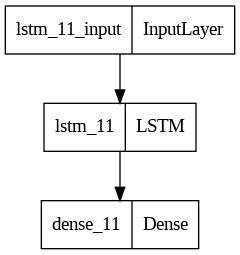

In [157]:
tf_randomness_control(0)
lstm_win_model = keras.models.Sequential()
lstm_win_model.add(keras.layers.LSTM(units=100, input_shape=(data_time_window.shape[1],nfeature)))
lstm_win_model.add(keras.layers.Dense(units=1 ))
lstm_win_model.compile(optimizer=tensorflow.keras.optimizers.Adam(),loss=tensorflow.keras.losses.mean_squared_error,metrics=tensorflow.metrics.MeanAbsoluteError())
lstm_win_model.summary()
keras.utils.plot_model(lstm_win_model)


# **train model**

In [158]:
lstm_win_model_hist=lstm_win_model.fit(train_data,train_lbl,epochs=my_epoch,batch_size=my_batch_size,shuffle=False)


Epoch 1/500
3/3 [==============================] - 2s 10ms/step - loss: 0.3293 - mean_absolute_error: 0.4453
Epoch 2/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1158 - mean_absolute_error: 0.2673
Epoch 3/500
3/3 [==============================] - 0s 8ms/step - loss: 0.0231 - mean_absolute_error: 0.1345
Epoch 4/500
3/3 [==============================] - 0s 10ms/step - loss: 0.0252 - mean_absolute_error: 0.1525
Epoch 5/500
3/3 [==============================] - 0s 8ms/step - loss: 0.0349 - mean_absolute_error: 0.1708
Epoch 6/500
3/3 [==============================] - 0s 8ms/step - loss: 0.0143 - mean_absolute_error: 0.0985
Epoch 7/500
3/3 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0481
Epoch 8/500
3/3 [==============================] - 0s 10ms/step - loss: 0.0072 - mean_absolute_error: 0.0725
Epoch 9/500
3/3 [==============================] - 0s 9ms/step - loss: 0.0115 - mean_absolute_error: 0.0968
Epoch 10/500
3/3 [=======

# **plot loss and metrics**

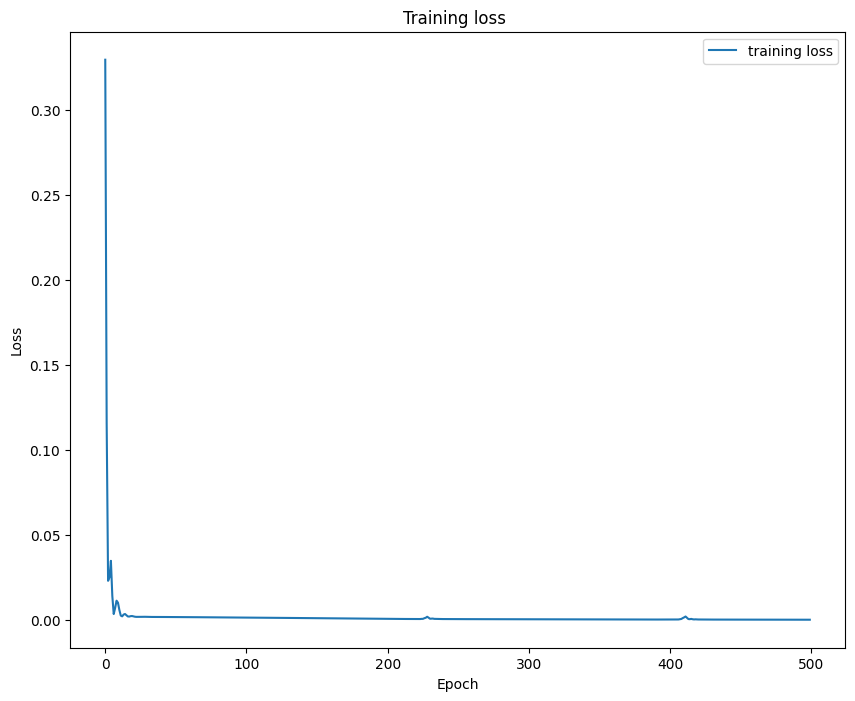

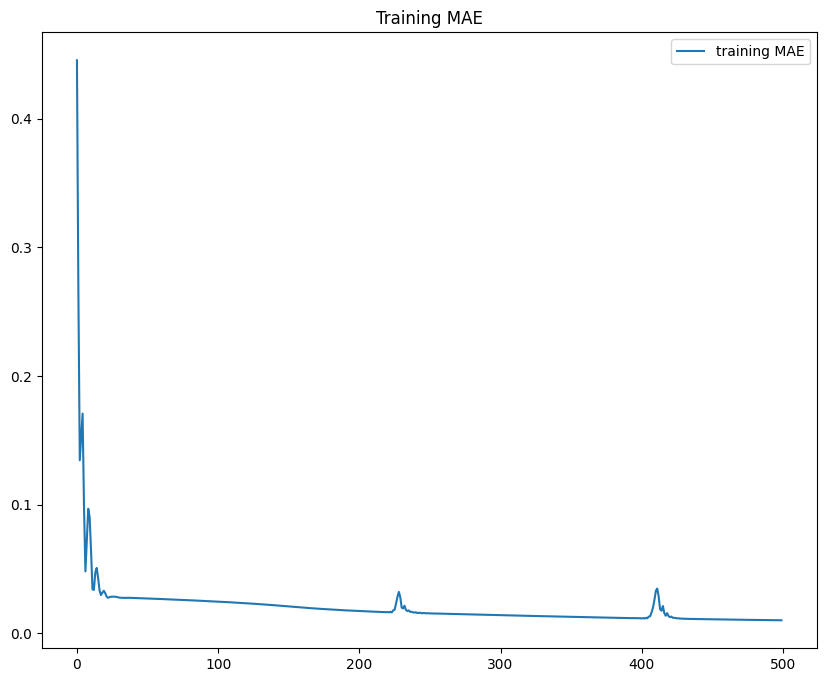

In [159]:
MAE = lstm_win_model_hist.history['mean_absolute_error']
loss = lstm_win_model_hist.history['loss']

plt.figure(figsize=(10,8))
plt.plot(range(my_epoch), loss, label='training loss')
plt.legend(loc='upper right')
plt.title('Training loss ')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.figure(figsize=(10,8))
plt.plot(range(my_epoch), MAE, label='training MAE' )
plt.legend(loc='upper right')
plt.title('Training MAE')
plt.show()


# **test LSTM model**

In [160]:

y_pred_lstm_win=lstm_win_model.predict(test_data,verbose=0 )
train_pred_lstm_win=lstm_win_model.predict(train_data,verbose=0 )
mse=metrics.mean_squared_error(test_lbl, y_pred_lstm_win)
rmse=metrics.mean_squared_error(test_lbl, y_pred_lstm_win,squared=False)
mae= metrics.mean_absolute_error(test_lbl,y_pred_lstm_win)

print('Mean squared error (MSE): %.3f ' % mse)
print('Root mean square error (RMSE) : %.3f '%rmse)
print('Mean Absolute Error (MAE): %.3f'%mae)
print("R2 Score: %.3f" %r2_score(test_lbl,y_pred_lstm_win))


Mean squared error (MSE): 0.000 
Root mean square error (RMSE) : 0.021 
Mean Absolute Error (MAE): 0.016
R2 Score: 0.935


# **plot train and test predictions vs. real price**

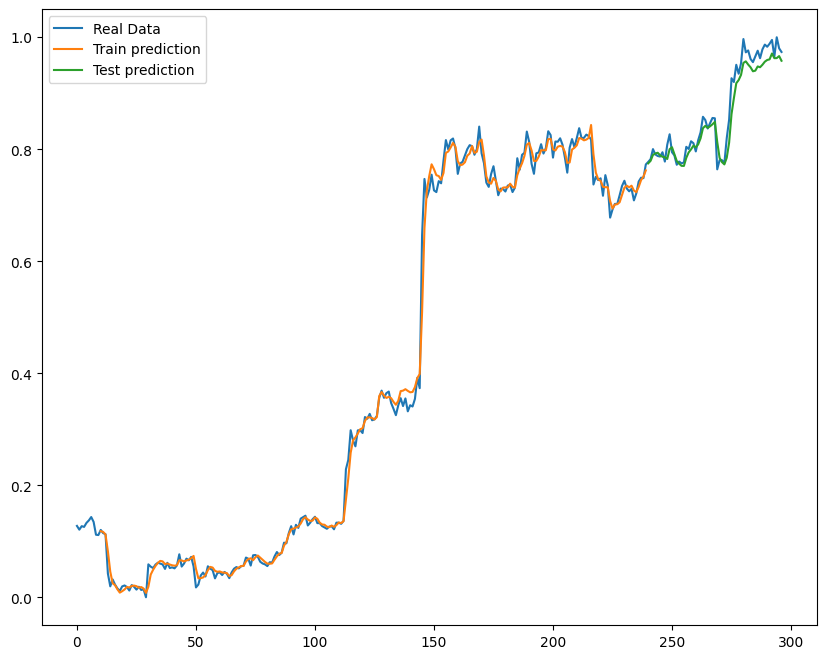

In [142]:
plot_train_test(train_pred_lstm_win,y_pred_lstm_win)

# **GRU model**

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 10)                540       
                                                                 
 dense_12 (Dense)            (None, 1)                 11        
                                                                 
Total params: 551 (2.15 KB)
Trainable params: 551 (2.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


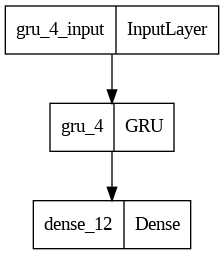

In [161]:
tf_randomness_control(0)
GRU_model = keras.models.Sequential()
GRU_model.add(keras.layers.GRU(units=10,  input_shape=(data_time_window.shape[1],nfeature)))
GRU_model.add(keras.layers.Dense(units=1 ))
GRU_model.compile(optimizer="Adam",loss=keras.losses.mean_squared_error,metrics=tensorflow.metrics.MeanAbsoluteError())
GRU_model.summary()
keras.utils.plot_model(GRU_model)


In [162]:
GRU_model_hist=GRU_model.fit(train_data,train_lbl,epochs=my_epoch,batch_size=my_batch_size )


Epoch 1/500
3/3 [==============================] - 2s 10ms/step - loss: 0.1063 - mean_absolute_error: 0.2707
Epoch 2/500
3/3 [==============================] - 0s 7ms/step - loss: 0.0708 - mean_absolute_error: 0.2296
Epoch 3/500
3/3 [==============================] - 0s 7ms/step - loss: 0.0441 - mean_absolute_error: 0.1890
Epoch 4/500
3/3 [==============================] - 0s 7ms/step - loss: 0.0269 - mean_absolute_error: 0.1548
Epoch 5/500
3/3 [==============================] - 0s 8ms/step - loss: 0.0161 - mean_absolute_error: 0.1224
Epoch 6/500
3/3 [==============================] - 0s 8ms/step - loss: 0.0104 - mean_absolute_error: 0.0938
Epoch 7/500
3/3 [==============================] - 0s 7ms/step - loss: 0.0067 - mean_absolute_error: 0.0711
Epoch 8/500
3/3 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_absolute_error: 0.0571
Epoch 9/500
3/3 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0439
Epoch 10/500
3/3 [=========

# **plot loss and metric**

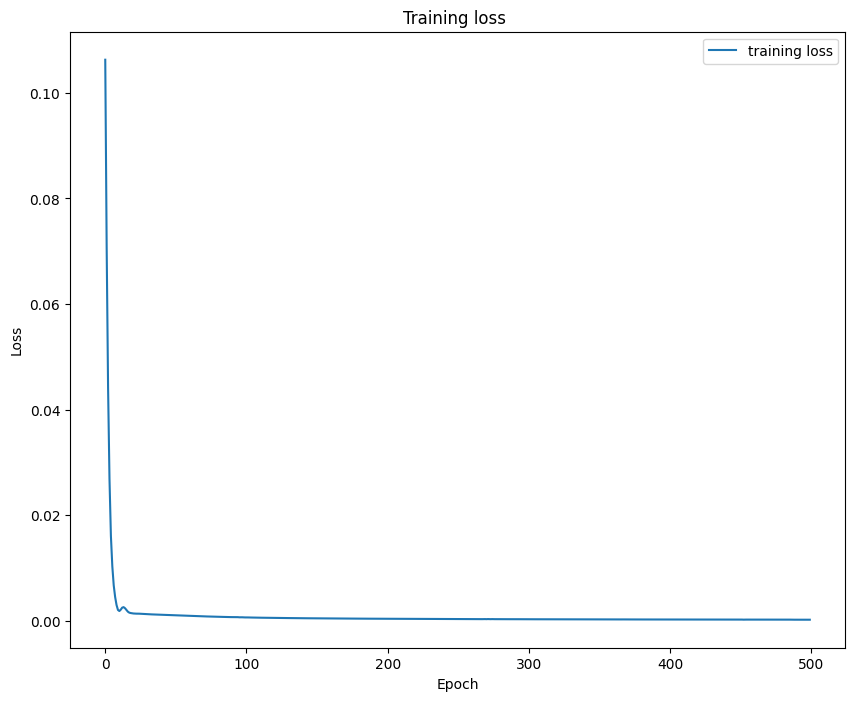

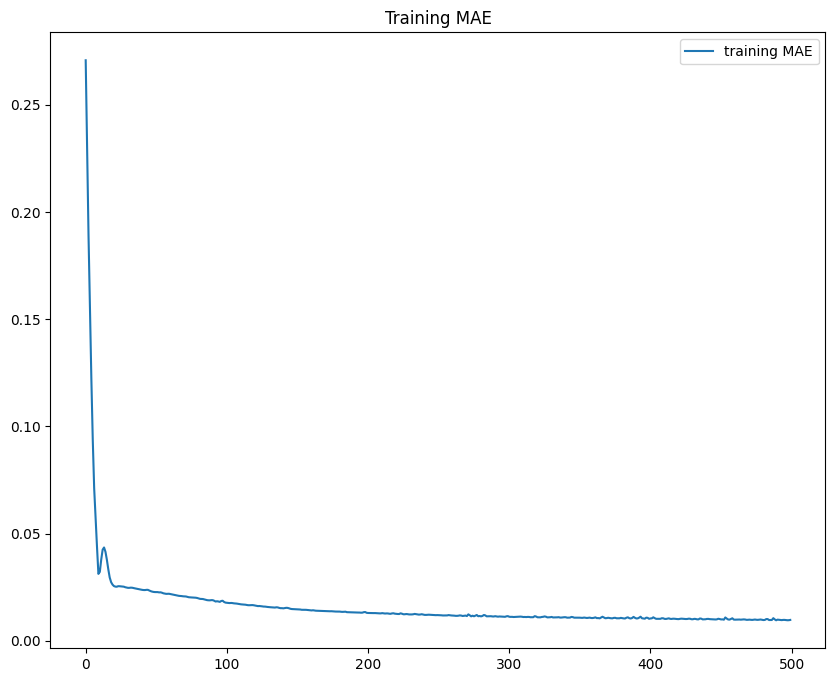

In [125]:

MAE = GRU_model_hist.history['mean_absolute_error']
loss = GRU_model_hist.history['loss']

plt.figure(figsize=(10,8))
plt.plot(range(my_epoch), loss, label='training loss')
plt.legend(loc='upper right')
plt.title('Training loss ')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.figure(figsize=(10,8))
plt.plot(range(my_epoch), MAE, label='training MAE' )
plt.legend(loc='upper right')
plt.title('Training MAE')
plt.show()

# **test GRU model**

In [126]:
y_pred_GRU=GRU_model.predict(test_data,verbose=0)
train_pred_GRU=GRU_model.predict(train_data,verbose=0)
mse=metrics.mean_squared_error(test_lbl, y_pred_GRU)
rmse=metrics.mean_squared_error(test_lbl, y_pred_GRU,squared=False)
mae= metrics.mean_absolute_error(test_lbl,y_pred_GRU)


print('Mean squared error (MSE): %.3f ' % mse)
print('Root mean square error (RMSE) : %.3f '%rmse)
print('Mean Absolute Error (MAE): %.3f'%mae)
print("R2 Score: %.3f" % r2_score(test_lbl,y_pred_GRU ))


Mean squared error (MSE): 0.001 
Root mean square error (RMSE) : 0.030 
Mean Absolute Error (MAE): 0.024
R2 Score: 0.868


# **plot train and test predictions vs. real price**

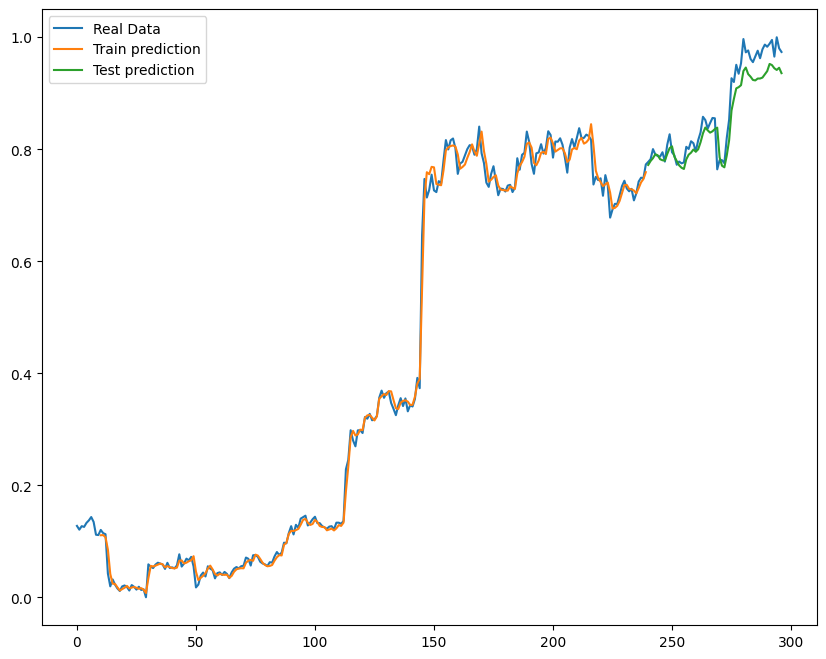

In [127]:
plot_train_test(train_pred_GRU,y_pred_GRU)

# **Bidirectional model**

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 200)               85600     
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 85801 (335.16 KB)
Trainable params: 85801 (335.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


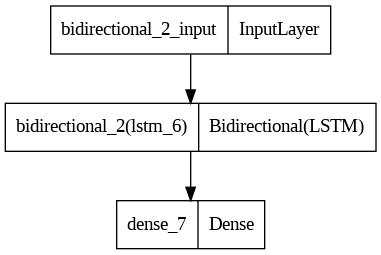

In [128]:
tf_randomness_control(0)
Bidir_model = keras.models.Sequential()
Bidir_model.add(Bidirectional(keras.layers.LSTM(units=100),input_shape=(data_time_window.shape[1],nfeature)))
Bidir_model.add(keras.layers.Dense(units=1 ))
Bidir_model.compile(optimizer="Adam",loss=keras.losses.mean_squared_error,metrics=tensorflow.metrics.MeanAbsoluteError())
Bidir_model.summary()
keras.utils.plot_model(Bidir_model)

# **train model**

In [129]:
Bidir_model_hist=Bidir_model.fit(train_data,train_lbl,epochs=my_epoch,batch_size=my_batch_size )

Epoch 1/500
3/3 [==============================] - 4s 11ms/step - loss: 0.1273 - mean_absolute_error: 0.2777
Epoch 2/500
3/3 [==============================] - 0s 9ms/step - loss: 0.0129 - mean_absolute_error: 0.0837
Epoch 3/500
3/3 [==============================] - 0s 9ms/step - loss: 0.0413 - mean_absolute_error: 0.1616
Epoch 4/500
3/3 [==============================] - 0s 9ms/step - loss: 0.0095 - mean_absolute_error: 0.0719
Epoch 5/500
3/3 [==============================] - 0s 9ms/step - loss: 0.0054 - mean_absolute_error: 0.0545
Epoch 6/500
3/3 [==============================] - 0s 9ms/step - loss: 0.0113 - mean_absolute_error: 0.0836
Epoch 7/500
3/3 [==============================] - 0s 9ms/step - loss: 0.0092 - mean_absolute_error: 0.0708
Epoch 8/500
3/3 [==============================] - 0s 11ms/step - loss: 0.0041 - mean_absolute_error: 0.0475
Epoch 9/500
3/3 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_absolute_error: 0.0415
Epoch 10/500
3/3 [========

# **plot loss and metric**

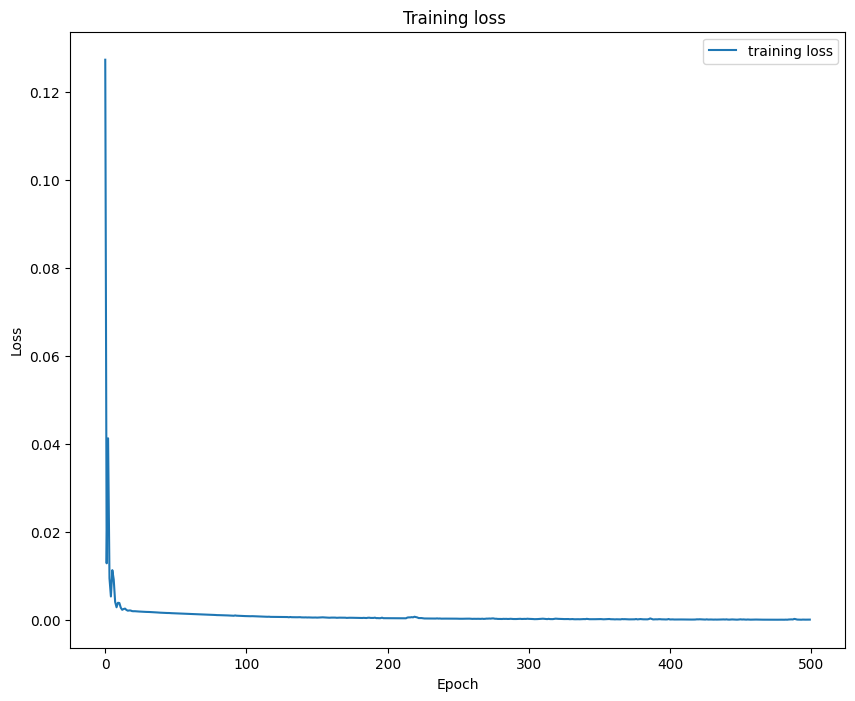

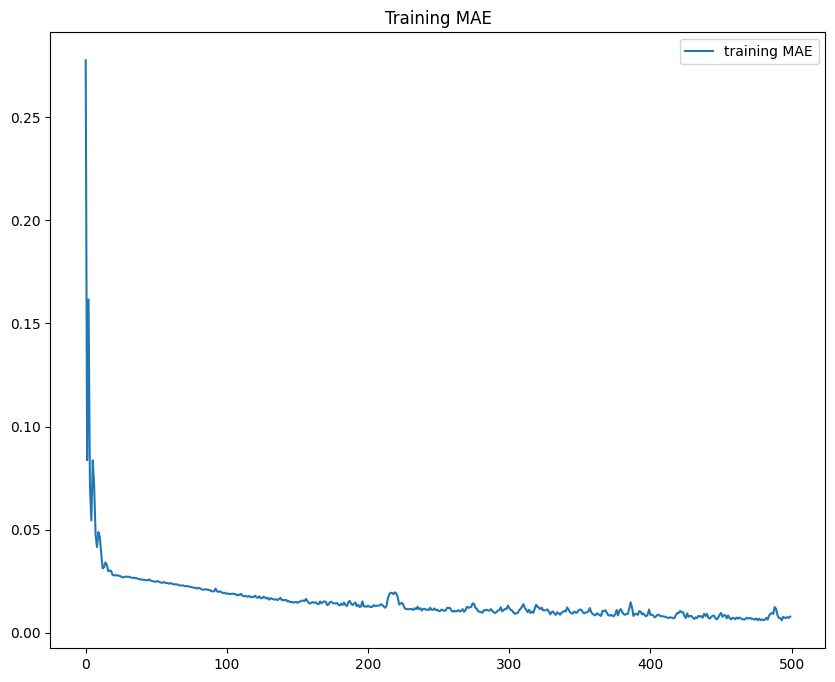

In [130]:

MAE = Bidir_model_hist.history['mean_absolute_error']
loss = Bidir_model_hist.history['loss']

plt.figure(figsize=(10,8))
plt.plot(range(my_epoch), loss, label='training loss')
plt.legend(loc='upper right')
plt.title('Training loss ')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.figure(figsize=(10,8))
plt.plot(range(my_epoch), MAE, label='training MAE' )
plt.legend(loc='upper right')
plt.title('Training MAE')
plt.show()

# **test bidirectional  model**

In [131]:
y_pred_Bidir=Bidir_model.predict(test_data,verbose=0)
train_pred_Bidir=Bidir_model.predict(train_data,verbose=0)
mse=metrics.mean_squared_error(test_lbl, y_pred_Bidir)
rmse=metrics.mean_squared_error(test_lbl, y_pred_Bidir,squared=False)
mae= metrics.mean_absolute_error(test_lbl,y_pred_Bidir)
print('Mean squared error (MSE): %.3f ' % mse)
print('Root mean square error (RMSE) : %.3f '%rmse)
print('Mean Absolute Error (MAE): %.3f'%mae)
print("R2 Score: %.3f" % r2_score(test_lbl,y_pred_Bidir ))


Mean squared error (MSE): 0.001 
Root mean square error (RMSE) : 0.029 
Mean Absolute Error (MAE): 0.026
R2 Score: 0.881


# **plot train and test predictions vs. real price**

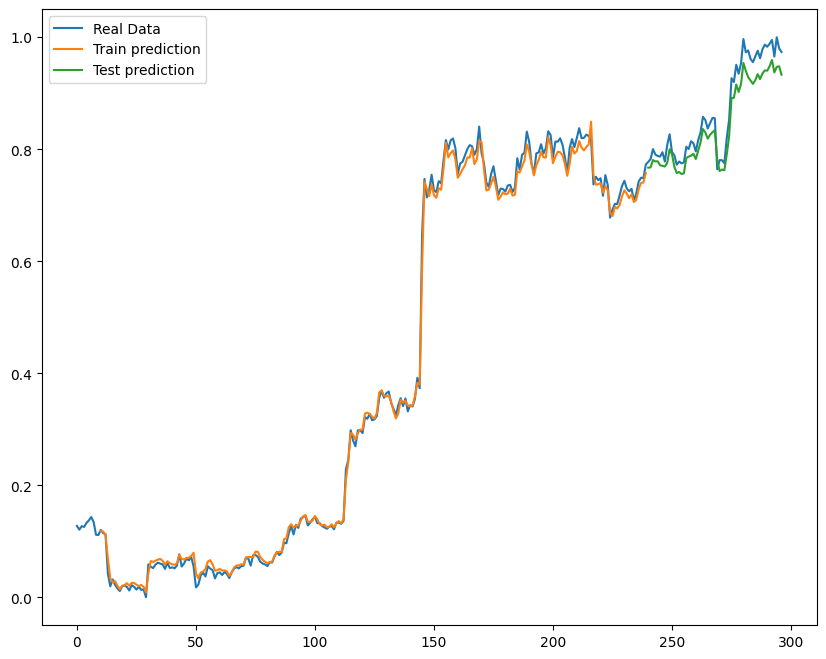

In [132]:
plot_train_test(train_pred_Bidir,y_pred_Bidir)

# **Hybrid Model**

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 10, 80)            27840     
                                                                 
 bidirectional_4 (Bidirecti  (None, 10, 80)            38720     
 onal)                                                           
                                                                 
 gru_5 (GRU)                 (None, 80)                38880     
                                                                 
 dense_13 (Dense)            (None, 1)                 81        
                                                                 
Total params: 105521 (412.19 KB)
Trainable params: 105521 (412.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


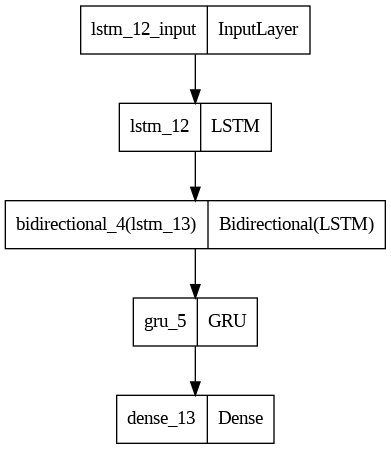

In [163]:
tf_randomness_control(0)
hybrid_model = keras.models.Sequential()
hybrid_model.add(keras.layers.LSTM(units=80,return_sequences=True,  input_shape=(data_time_window.shape[1],nfeature)))
hybrid_model.add(Bidirectional(keras.layers.LSTM(units=40,return_sequences=True)))
hybrid_model.add(keras.layers.GRU(units=80))
hybrid_model.add(keras.layers.Dense(units=1 ))
hybrid_model.compile(optimizer="Adam",loss=keras.losses.mean_squared_error,metrics=tensorflow.metrics.MeanAbsoluteError())
hybrid_model.summary()
keras.utils.plot_model(hybrid_model)

# **train model**

In [164]:
hybrid_model_hist=hybrid_model.fit(train_data,train_lbl,epochs=my_epoch,batch_size=50,shuffle=False)

Epoch 1/500
5/5 [==============================] - 7s 13ms/step - loss: 0.1455 - mean_absolute_error: 0.2835
Epoch 2/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0153 - mean_absolute_error: 0.1104
Epoch 3/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0113 - mean_absolute_error: 0.0983
Epoch 4/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0154 - mean_absolute_error: 0.1098
Epoch 5/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0054 - mean_absolute_error: 0.0586
Epoch 6/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0055 - mean_absolute_error: 0.0616
Epoch 7/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0045 - mean_absolute_error: 0.0566
Epoch 8/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_absolute_error: 0.0456
Epoch 9/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0032 - mean_absolute_error: 0.0411
Epoch 10/500
5/5 [=

# **test hybrid model**

In [135]:
y_pred_hybrid=hybrid_model.predict(test_data,verbose=0)
train_pred_hybrid=hybrid_model.predict(train_data,verbose=0)
mse=metrics.mean_squared_error(test_lbl, y_pred_hybrid)
rmse=metrics.mean_squared_error(test_lbl, y_pred_hybrid,squared=False)
mae= metrics.mean_absolute_error(test_lbl,y_pred_hybrid)
print('Mean squared error (MSE): %.3f ' % mse)
print('Root mean square error (RMSE) : %.3f '%rmse)
print('Mean Absolute Error (MAE): %.3f'%mae)
print("R2 Score: %.3f" % r2_score(test_lbl,y_pred_hybrid ))


Mean squared error (MSE): 0.000 
Root mean square error (RMSE) : 0.013 
Mean Absolute Error (MAE): 0.010
R2 Score: 0.977


# **plot loss and metric**

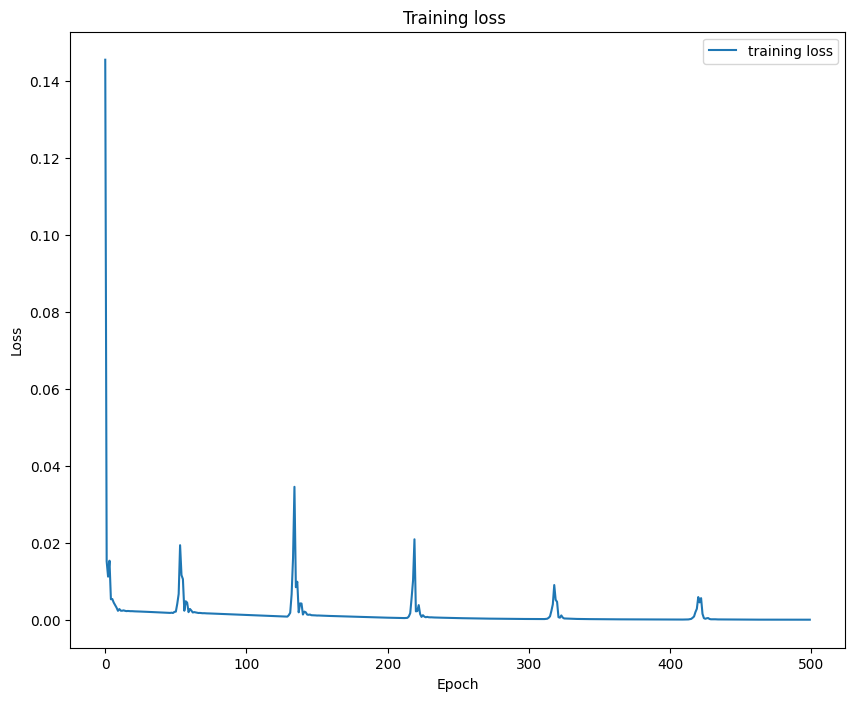

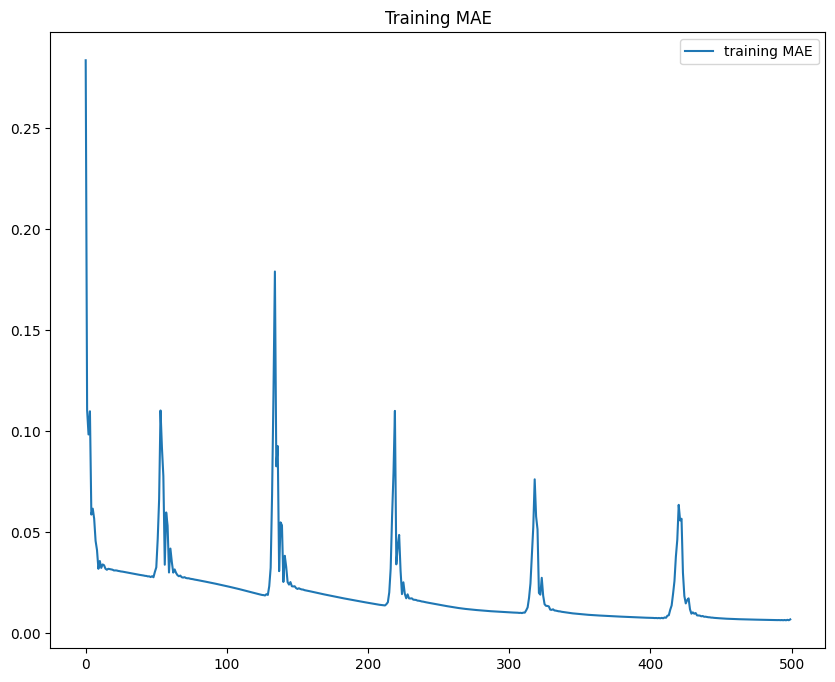

In [136]:
MAE = hybrid_model_hist.history['mean_absolute_error']
loss = hybrid_model_hist.history['loss']

plt.figure(figsize=(10,8))
plt.plot(range(my_epoch), loss, label='training loss')
plt.legend(loc='upper right')
plt.title('Training loss ')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.figure(figsize=(10,8))
plt.plot(range(my_epoch), MAE, label='training MAE' )
plt.legend(loc='upper right')
plt.title('Training MAE')
plt.show()

# **plot train and test predictions vs. real price**

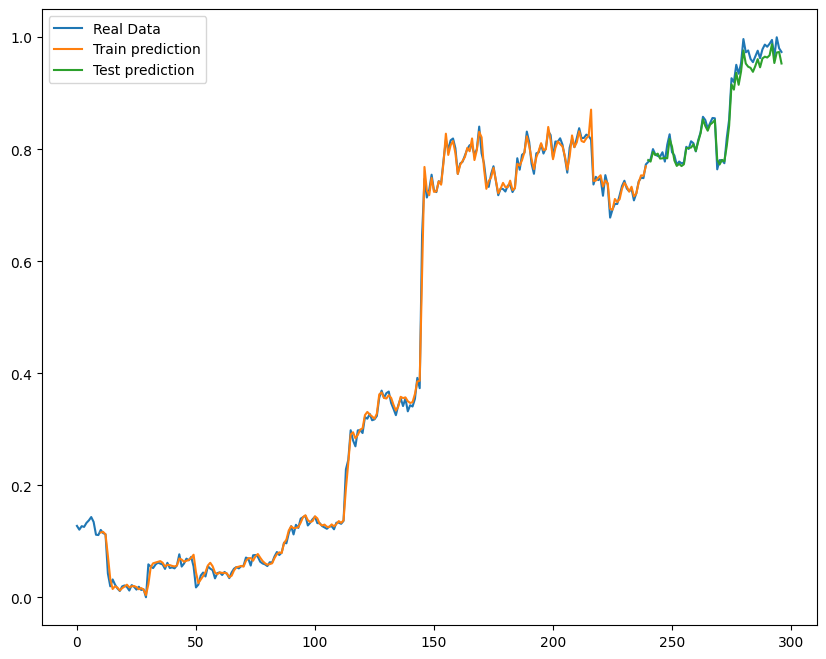

In [137]:
plot_train_test(train_pred_hybrid,y_pred_hybrid)